In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as ani
from scipy.spatial import Voronoi, Delaunay
from random import uniform
import time

In [2]:
def ray_tracing_numpy(x, y, poly) -> np.ndarray:
    n = len(poly)
    inside = np.zeros(len(x), np.bool_)
    p2x = 0.0
    p2y = 0.0
    xints = 0.0
    p1x, p1y = poly[0]
    
    for i in range(n + 1):
        p2x,p2y = poly[i % n]
        idx = np.nonzero((y > min(p1y, p2y)) & (y <= max(p1y, p2y)) & (x <= max(p1x, p2x)))[0]
        if p1y != p2y: 
            xints = (y[idx] - p1y) * (p2x - p1x) / (p2y - p1y) + p1x
        if p1x == p2x:
            inside[idx] = ~inside[idx]
        else:
            idxx = idx[x[idx] <= xints]
            inside[idxx] = ~inside[idxx]
        p1x, p1y = p2x, p2y
    return inside

In [3]:
def reflect(gen: np.ndarray, bdPts: np.ndarray) -> np.ndarray:
    """reflect near-boundary points in domain enclosed by 'bdPts' across boundary
    
    @param  gen - (np.ndarray) 
    @param  bdPts - (np.ndarray)
    @return (list[list[real]]) reflected points
    """
    N = len(gen);
    m = len(bdPts);
    #firt loop boundary back around
    bdPts = np.vstack( [bdPts, bdPts[0,:]] )
    
    #Below should be approx the number of boundary nodes at each Add nodes on the boundary
    bdN = np.ceil(0.5*np.sqrt(N));#maybe +1
    h = 1.0/bdN;
    lambdaLS = np.linspace(h,1-h,int(bdN-1))# going to use barycentric weights for boundary edge
    N_lambda = len(lambdaLS)
    fill = np.zeros([int(m*(bdN - 1)),2])
    allNode = np.vstack( [gen, np.zeros([int(m*(bdN-1)),2]), bdPts[0:m,:]] )
    bigN = len(allNode);
    isBdAddNode = np.zeros([bigN,m], dtype=bool)
    tempNode = np.zeros([N_lambda,2])
    for i in range(m):
        tempNode[:,0] = (1-lambdaLS)*bdPts[i,0]+lambdaLS*bdPts[i+1,0]; 
        tempNode[:,1] = (1-lambdaLS)*bdPts[i,1]+lambdaLS*bdPts[i+1,1];
        leftN = int(N+(i)*(bdN-1))
        rightN = int(N+(i+1)*(bdN-1))
        allNode[leftN:rightN,:] = tempNode
        isBdAddNode[leftN:rightN,i] = True;
        if i < m-1:
            leftN = int(N+m*(bdN-1)+i)
            rightN = int(N+m*(bdN-1)+i+2)
            isBdAddNode[leftN:rightN,i] = True;
        else:
            leftN = int(N+m*(bdN-1)+i)
            rightN = int(N+m*(bdN-1)+2)
            isBdAddNode[leftN:rightN,i] = True;
    
    tri = Delaunay(allNode)
    elem = tri.simplices
    
    #for debugging
    #plt.triplot(allNode[:,0], allNode[:,1], tri.simplices)
    #plt.plot(allNode[:,0], allNode[:,1], 'o')
    #plt.show()
    elemN = len(elem)
    isRefNode = np.zeros([bigN,m], dtype=bool)
    for i in range(m):
        #Create logical arrays for identifying connectivity
        isNearBdNode = np.zeros([bigN,1], dtype=bool);        
        isBdElem = isBdAddNode[elem[:,0],i] + isBdAddNode[elem[:,1],i] + isBdAddNode[elem[:,2],i]
        isNearBdNode[elem[isBdElem,:]] = True;
        #Find nodes near boundary
        isBdElem = isNearBdNode[elem[:,0]] + isNearBdNode[elem[:,1]] + isNearBdNode[elem[:,2]]
        elemN = len(elem[isBdElem[:,0],:])
        maskRefNode = np.unique(np.reshape(elem[isBdElem[:,0],:],(elemN*3,1)))
        isRefNode[maskRefNode,i] = True
        isRefNode[N+1:bigN,i] = False
        
    isRefNode = isRefNode[0:N,:]
    ###Reflect generators for each boundary segment
    allNode = np.zeros([4*N,2])
    allNode[0:N,:] = gen
    switchPair = np.zeros([100,2])
    sN = 0
    currentN = N
    for i in range(m):
        # reflection of near boundary nodes
        r2 = np.sqrt((bdPts[i+1,0] - bdPts[i,0])**2 + (bdPts[i+1,1] - bdPts[i,1])**2)
        costheta = (bdPts[i+1,0] - bdPts[i,0])/r2
        sintheta = (bdPts[i+1,1] - bdPts[i,1])/r2
        maskRefNode = np.array(isRefNode[:,i]).astype(np.bool)
#         tempMatMulti = np.reshape(
#             np.vstack([gen[maskRefNode,0] - bdPts[i,0],gen[maskRefNode,1] - bdPts[i,1]]),
#             [len(gen[maskRefNode,0]),2])
        tempMatMulti = np.transpose(np.vstack([gen[maskRefNode,0] - bdPts[i,0],
                                               gen[maskRefNode,1] - bdPts[i,1]]))
        #rotate to y axis
        tempNode = np.matmul(tempMatMulti,[[costheta, -sintheta],[sintheta, costheta]])
        #reflect over to y axis
        tempNode[:,1] = -tempNode[:,1]
        #inverse rotation
        tempNode = np.matmul(tempNode,[[costheta, sintheta],[-sintheta, costheta]])
#         refNode = np.reshape(np.vstack([tempNode[:,0] + bdPts[i,0], tempNode[:,1] + bdPts[i,1]]),
#                              [len(tempNode),2])
        refNode = np.transpose(np.vstack([tempNode[:,0] + bdPts[i,0], tempNode[:,1] + bdPts[i,1]]))
        addN =  np.size(refNode,0)
        #append reflective points
        refNodeRange = currentN + np.arange(addN)
#         print(refNodeRange)
        allNode[refNodeRange,:] = refNode
        currentN = currentN + addN
        #record generators outside of the domain with their reflection
        inLogic = ray_tracing_numpy(gen[isRefNode[:,i],0],gen[isRefNode[:,i],1],bdPts[:m])
        if (sum(inLogic) != len(inLogic)):
            inRef = ray_tracing_numpy(refNode[not inLogic,0],refNode[not inLogic,1],bdPts[:m])
            # something went wrong, need to add below to switch the reflection with the generator (nonconvex)
            if (sum(inRef) != len(inRef)):
                #switchPair[sN + np.arange(sum(inRef)),:] = [refNodeIdx(out(inRef)) refNodeRange(out(inRef))];
                sN = sN + sum(inRef)
                
    allNode = allNode[:currentN,:]
    
    return allNode

In [4]:
def reformat_cells(cells: list, generators: np.ndarray) -> list:
    """reformat 'cells' into a format compatible with other functions
    
    @param  cells - (?) cells given by Voronoi()
    @return (np.ndarray) list of cells; 
            each cell consists of a list of triangles; 
            each triangle consists of list of vertices in counter-clockwise order
    """
    answer = []
    
    for i, cell in enumerate(cells):
        # note the generator of the current cell
        gen = generators[i]
        
        # sort the vertices of the cell/polygon in counter-clockwise order
        # using the inverse tangent function as key
        curr = sorted(cell, key = lambda p : np.arctan2(p[1] - gen[1], p[0] - gen[0]))
        
        # every adjacent pair of elements in 'curr' plus the generator
        # form a triangle in the correct orientation; just gather them up here
        temp = [[gen, curr[i], curr[i - 1]] for i in range(1, len(curr))]
        temp.append([gen, curr[0], curr[-1]])
        answer.append(temp)
        
    return answer

In [5]:
# Hard-coded points and weights for Gaussian quadrature
# TODO -- find points and weights for higher order precision
POINTS_X = [1/3, 1/5, 3/5, 1/5]
POINTS_Y = [1/3, 1/5, 1/5, 3/5]
WEIGHTS = [-27/96, 25/96, 25/96, 25/96]

def integrate(domain: np.ndarray, function) -> float:
    """integrate 'function' over 'domain' that is a triangle in R2
    
    @param  domain - (np.ndarray) three vertices of a triangle
    @param  function - (f : R2 -> R2) function to be integrated
    @param  (real) result evaluated using Gaussian quadrature
    
    Change of variable: use standard basis vectors e1, e2.
    If the domain is [[a1, a2], [b1, b2], [c1, c2]], then the transformation is
        x = (b1 - a1) * e1 + (c1 - a1) * e2 + a1
        y = (b2 - a2) * e1 + (c2 - a2) * e2 + a2
    The Jacobian of this transformation is
        [[b1 - a1, c1 - a1], 
         [b2 - a2, c2 - a2]]
    The determinant of the Jacobian is
        (b1 - a1) * (c2 - a2) - (b2 - a2) * (c1 - a1)
    """
    numerator = lambda x, y : density(x, y) * np.ndarray((x, y))
    
    a, b, c = domain  # unpack 'domain' into 3 variables
    jacobian = (b[0] - a[0]) * (c[1] - a[1]) - (b[1] - a[1]) * (c[0] - a[0])
    
    # Gaussian quadrature with variable-changed function
    
#     answer = 0
#     for u, v, w in zip(POINTS_X, POINTS_Y, WEIGHTS):
#         test = (b - a) * u + (c - a) * v + a
#         answer += jacobian * w * function(*((b - a) * u + (c - a) * v + a))
#     return answer
    
    return sum(jacobian * w * function(*((b - a) * u + (c - a) * v + a))
               for u, v, w in zip(POINTS_X, POINTS_Y, WEIGHTS))
    
#     return sum(jacobian * w * function((b[0] - a[0]) * u + (c[0] - a[0]) * v + a[0], 
#                                        (b[1] - a[1]) * u + (c[1] - a[1]) * v + a[1]) 
#                for u, v, w in zip(POINTS_X, POINTS_Y, WEIGHTS))

In [6]:
def get_centroid_gradient(vor, density, generators: np.ndarray, gradient: np.ndarray) -> None:
    """find the centroid of each cell and also the gradient of energy
    
    @param  vor - (scipy.spatial.qhull.Voronoi) Voronoi diagram object
    @param  density - (lambda real, real) density function over the overall domain
    @param  generators - (np.ndarray) generators of the current iteration (this param is modified)
    @param  gradient - (np.ndarray) array to store the gradient (this param is modified)
    
    To compute the centroid of a given cell which is a polygon, 
        we split the cell into triangles and integrate each triangle.
    The two coordinates are computed separately, then added to 'answer'
        that gathers all the centroids
        
    To compute the ith component of the gradient, we use the formula
        2 * mass[i] * (generators[i] - centroids[i])
    """
    
    numerator = lambda x, y : density(x, y) * np.array((x, y))
    
    for gen_i, reg_i in enumerate(vor.point_region[:n]):
#         start = time.time()
        # create NumPy array for current cell by putting the generators as first value
        # 'cell' contains ...
        cell = np.zeros((len(vor.regions[reg_i]), 3, 2))
        cell[:, 0] = generators[gen_i]
#         print('create cell:', time.time() - start)
        
#         start = time.time()
        # put in the rest of ...
        vert = sorted((vor.vertices[j] for j in vor.regions[reg_i]), 
                      key = lambda p : np.arctan2(p[1] - generators[gen_i][1], p[0] - generators[gen_i][0]))
#         print('sort vertices:', time.time() - start)
        
#         start = time.time()
        for j in range(len(vert)):
            cell[j, 1:3] = vert[j], vert[(j + 1) % len(vert)]
#         print('complete cell:', time.time() - start)
        
#         start = time.time()
        top = sum(integrate(triangle, numerator) for triangle in cell)
        mass = sum(integrate(triangle, density) for triangle in cell)
#         print('integrate:', time.time() - start)
    
        gradient[gen_i] = 2 * mass * (generators[gen_i] - top / mass)
        generators[gen_i] = top / mass
        
#         gradient[gen_i] = 2 * mass * (generators[gen_i] - (x / mass, y / mass))
#         generators[gen_i] = x / mass, y / mass

In [7]:
def plot_voronoi(n: int, vor) -> None:
    """plot the Voronoi cells stored in object 'vor'
    
    @param  n - (int) number of generators
    @param  vor - (scipy.spatial.qhull.Voronoi) Voronoi diagram object
    """
    for i in vor.point_region[:n]:
        ver = [vor.vertices[j] for j in vor.regions[i]]
        ver.append(ver[0])
        plt.plot(*zip(*ver))

In [8]:
def lloyd(n: int, domain: np.ndarray, init: np.ndarray, density, tolerance: float) -> int:
    """Lloyd's method with domain, initial guess points, and density function
    
    @param  n - (int) number of generators
    @param  domain - (np.ndarray) vertices of the polygon that is the domain
    @param  init - (np.ndarray) initial guess for generators of Voronoi cells
    @param  density - (lambda real, real) density function over 'domain'
    @return (int) number of iterations processed
    """
    curr = init  # updated in while-loop
    grad = np.ones((n, 2))  # initialize to 1 to enter while-loop
    iterations = 0  # will be returned at the end
    
    while grad.max() > tolerance * n:  # consider infinity norm
        # reflect generators near the boundaries across the boundaries
        temp = reflect(curr, domain)
        
        # obtain Voronoi diagram of the new generators
        vor = Voronoi(temp)
        
        # update 'curr' to the centroids of the current cells in 'vor'
        # update 'grad' to the current gradient of the energy
        get_centroid_gradient(vor, density, curr, grad)
        
        iterations += 1
        
            
    plot_voronoi(n, vor)
    if n <= 50:
        plt.scatter(*zip(*curr))
        
    return iterations

Number of iterations: 379
Finished in 6.183237791061401 seconds


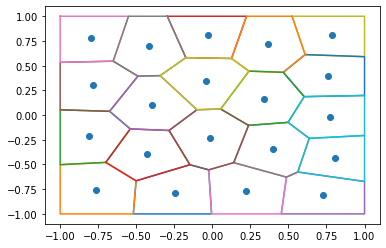

In [9]:
def exe_lloyd(n: int, domain: np.ndarray, density = lambda x, y : 1) -> None:
    """main method for executing Lloyd's method
    
    @param  n - (int) number of generators
    @param  domain - (np.ndarray) vertices of the polygon that is the domain
    @param  density - (lambda real, real) density function over 'domain'
    """
    start = time.time()
    
    # randomly generate 'n' points as generator
    init = 2 * np.random.rand(n, 2) - 1
    
    # perform Lloyd's method and plot the resulting cells and generators
    result = lloyd(n, domain, init, density, 10 ** -10)
    
    print(f"Number of iterations: {result}")
    print(f"Finished in {time.time() - start} seconds")
    


# testing
n = 20  # number of generators
domain = np.array([[1, 1], [-1, 1], [-1, -1], [1, -1]])
density = lambda x, y : np.exp(-5 * abs(1 - x**2 - y**2))
exe_lloyd(n, domain)


# include option to animate the generators as well as cells

# change list to np.array
# try hexagon, 2000 points


# next: use BFGS
# https://machinelearningmastery.com/bfgs-optimization-in-python/
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_bfgs.html